Local Fastpath Example
----------------------

Communication between two containers needs to be encrypted by default, but this is wasteful if they are on the same machine.

#### Goals
- show that negotiation can help us take advantage of locality to avoid expensive processing.

#### Experiment

Encryption via Ghostunnel (GT), accessed via uds.

- 'encr': `container 1 --(uds)-- GT --(tls+tcp)-- GT --(uds)-- container 2`
  - with GT, with reliability, without fastpath chunnel
- 'rel': `container 1 --(udp)-- container 2`
  - no GT, with reliability, without fastpath chunnel
- 'fp-rel': `container 1 --(uds)-- container 2` 
  - no GT, with reliability, with fastpath chunnel 
  - same as 'rel' if remote
- 'fp': `container 1 --(uds)-- container 2` 
  - yes GT, yes reliability, yes fastpath chunnel
  - same as 'encr' if remote


200 connections, 10 rpcs per connection
- respond immediately

Data files:
`{local|remote}-mode:{encr|rel|fp}-msgs:200-perconn:10.data`

In [2]:
import rpy2
import rpy2.robjects.lib.ggplot2 as ggplot2
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
base = importr('base')

# the base of rpy2 plotting is matplotlib, thus we need to declare
# it inline in order to see the plots in the notebook
%matplotlib inline

# we need to activate the automatic conversion for pandas
from rpy2.robjects import pandas2ri
pandas2ri.activate()

# load the needed extension for the %%R cell magic
%load_ext rpy2.ipython

import pandas as pd
import numpy as np

%config IPCompleter.greedy=True

import matplotlib.pylab as plt
plt.rcParams['figure.dpi'] = 200

In [3]:
pos = ['local', 'remote', 'farther']
mode = [f'mode:{m}' for m in ['encr', 'rel', 'rel-ux', 'fp', 'fp-rel', 'fp-rel2']]
msgs = ['msgs:200']
perconn = ['perconn:10']
version = ['with-rel', 'no-rel']


In [4]:
df = None
for d in version:
    for p in pos:
        for m in mode:
            for nummsg in msgs:
                for pc in perconn:
                    fn = f"{d}/{p}-{m}-{nummsg}-{pc}.data"
                    try:
                        file_df = pd.read_csv(fn, sep=",")
                    except:
                        continue
                    file_df['reliable'] = d
                    file_df['location'] = p
                    file_df['mode'] = m
                    file_df['nummsg'] = nummsg
                    file_df['perconn'] = pc
                    if df is None:
                        df = file_df
                    else:
                        df = df.append(file_df)
                    
df

,Elapsed_us,Total_us,Server_us,reliable,location,mode,nummsg,perconn
0,137573,8201,0,with-rel,local,mode:encr,msgs:200,perconn:10
1,137917,342,0,with-rel,local,mode:encr,msgs:200,perconn:10
2,138231,313,0,with-rel,local,mode:encr,msgs:200,perconn:10
3,138487,255,0,with-rel,local,mode:encr,msgs:200,perconn:10
4,138726,238,0,with-rel,local,mode:encr,msgs:200,perconn:10
...,...,...,...,...,...,...,...,...
1995,21339379,267,0,no-rel,remote,mode:fp-rel,msgs:200,perconn:10
1996,21339688,297,0,no-rel,remote,mode:fp-rel,msgs:200,perconn:10
1997,21339968,269,0,no-rel,remote,mode:fp-rel,msgs:200,perconn:10
1998,21340242,262,0,no-rel,remote,mode:fp-rel,msgs:200,perconn:10


In [6]:
df.to_csv("./local-fastpath-data.csv")

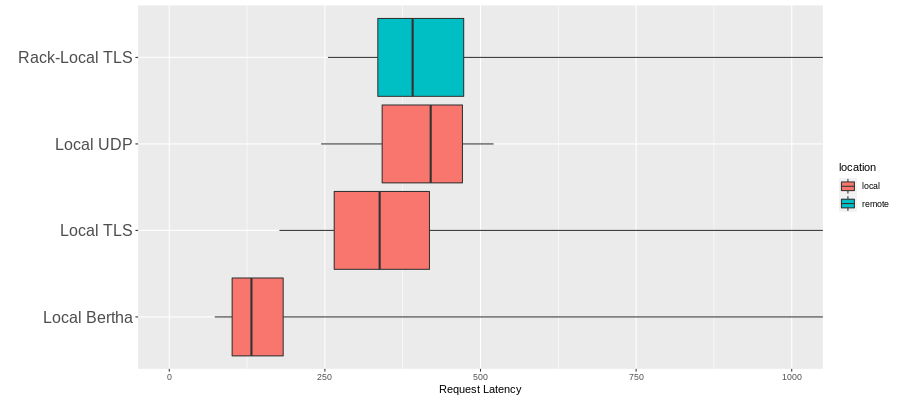

In [7]:
%%R -i df -w 900 -h 400

f <- function(x) {
  r <- quantile(x, probs = c(0.05, 0.25, 0.5, 0.75, 0.95))
  names(r) <- c("ymin", "lower", "middle", "upper", "ymax")
  r
}

norel <- df[df$reliable=="no-rel",]
ggplot(norel, aes(x=interaction(mode, location), y=Total_us, fill=location)) + 
  stat_summary(fun.data = f, geom="boxplot") + 
  scale_x_discrete(
      limits=c("mode:fp.local", "mode:encr.local", "mode:rel.local", "mode:fp.remote"),
      labels=c(
          "mode:fp.local" = "Local Bertha",
          "mode:encr.local" = "Local TLS",
          "mode:rel.local" = "Local UDP",
          "mode:fp.remote" = "Rack-Local TLS"
      )
  ) +
  xlab("") + ylab("Request Latency") +
  theme(
      axis.text.y = element_text(size=16)
  ) +
  coord_flip(ylim=c(0,1000))
#  stat_ecdf() +
#  scale_colour_discrete(limits=c("mode:fp.local", "mode:rel.local", "mode:encr.local", "mode:fp.remote")) +

Remaining Unresolved Questions
==============

- Why, WHY, does `mode:fp-rel.local` suddenly get worse than `mode:fp.local`???
- Why does this carry over to `mode:rel-ux.local`, which is also worse than expected?

Below are several exploratory graphs, including from instrumentation, showing this problem.

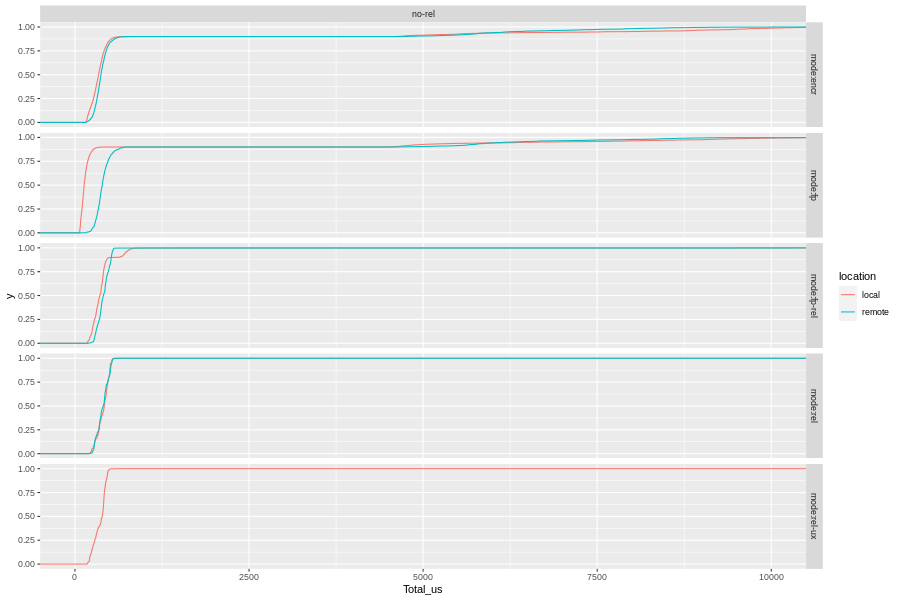

In [258]:
%%R -i df -w 900 -h 600

library(ggplot2)

ggplot(df[df$reliable=="no-rel",], aes(x=Total_us, colour=location)) + 
  stat_ecdf() + 
  facet_grid(mode~reliable) +
  coord_cartesian(xlim=c(0,10e3))

In [57]:
def parse_trace(fn):
    with open(fn) as f:
        for line in f:
            sp = line.split(":")
            if len(sp) != 4:
                continue
            _, ev, _, nums = sp
            ev = ev.split('(')[0].strip().replace(' ', '_')
            flds = ['min', 'p25', 'p50', 'p75', 'p95', 'max', 'cnt']
            n = [int(x) for x in nums.strip().split()]
            if len(n) != len(flds):
                print(f"{n} != {flds}")
                continue
            flds = {x:y for x, y in zip(flds, n)}
            flds['event'] = ev
            yield flds
            

In [246]:
df_trace = None
for d in version:
    for p in pos:
        for m in mode:
            for nummsg in msgs:
                for pc in perconn:
                    fn = f"{d}/{p}-{m}-{nummsg}-{pc}.trace"
                    try:
                        file_df = pd.DataFrame.from_records(parse_trace(fn))
                    except:
                        print(f"skip {fn}")
                        continue
                    file_df['reliable'] = d
                    file_df['location'] = p
                    file_df['mode'] = m
                    file_df['nummsg'] = nummsg
                    file_df['perconn'] = pc
                    if df_trace is None:
                        df_trace = file_df
                    else:
                        df_trace = df_trace.append(file_df)
                    
df_trace

skip with-rel/local-mode:rel-ux-msgs:200-perconn:10.trace
skip with-rel/local-mode:fp-rel-msgs:200-perconn:10.trace
skip with-rel/local-mode:fp-rel2-msgs:200-perconn:10.trace
skip with-rel/remote-mode:rel-ux-msgs:200-perconn:10.trace
skip with-rel/remote-mode:fp-rel-msgs:200-perconn:10.trace
skip with-rel/remote-mode:fp-rel2-msgs:200-perconn:10.trace
skip with-rel/farther-mode:encr-msgs:200-perconn:10.trace
skip with-rel/farther-mode:rel-msgs:200-perconn:10.trace
skip with-rel/farther-mode:rel-ux-msgs:200-perconn:10.trace
skip with-rel/farther-mode:fp-msgs:200-perconn:10.trace
skip with-rel/farther-mode:fp-rel-msgs:200-perconn:10.trace
skip with-rel/farther-mode:fp-rel2-msgs:200-perconn:10.trace
skip no-rel/local-mode:fp-rel2-msgs:200-perconn:10.trace
skip no-rel/remote-mode:rel-ux-msgs:200-perconn:10.trace
skip no-rel/remote-mode:fp-rel2-msgs:200-perconn:10.trace
skip no-rel/farther-mode:encr-msgs:200-perconn:10.trace
skip no-rel/farther-mode:rel-msgs:200-perconn:10.trace
skip no-rel/

,min,p25,p50,p75,p95,max,cnt,event,reliable,location,mode,nummsg,perconn
0,999424,1003519,1003519,1003519,1003519,1003519,200,Bound_to_udp_address,with-rel,local,mode:encr,msgs:200,perconn:10
1,40960,54527,56319,58367,68607,98815,200,client_negotiation_starting,with-rel,local,mode:encr,msgs:200,perconn:10
2,999424,1003519,1003519,1003519,1003519,1003519,200,applied_to_stack,with-rel,local,mode:encr,msgs:200,perconn:10
3,65536,108031,114687,122367,210943,1044479,200,starting_ghostunnel,with-rel,local,mode:encr,msgs:200,perconn:10
4,272384,557055,589823,622591,679935,757759,200,connecting_to_remote,with-rel,local,mode:encr,msgs:200,perconn:10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
42,2320,2431,2463,2511,2559,5247,200,client_negotiation_starting,no-rel,remote,mode:fp-rel,msgs:200,perconn:10
43,430080,614399,634879,655359,671743,1003519,200,"received_server_pairs,_applying",no-rel,remote,mode:fp-rel,msgs:200,perconn:10
44,7456,7903,7999,8127,8639,33279,200,checking_apply,no-rel,remote,mode:fp-rel,msgs:200,perconn:10
45,5728,5951,6079,6207,6335,10495,200,applied_to_stack,no-rel,remote,mode:fp-rel,msgs:200,perconn:10


R[write to console]: Coordinate system already present. Adding new coordinate system, which will replace the existing one.



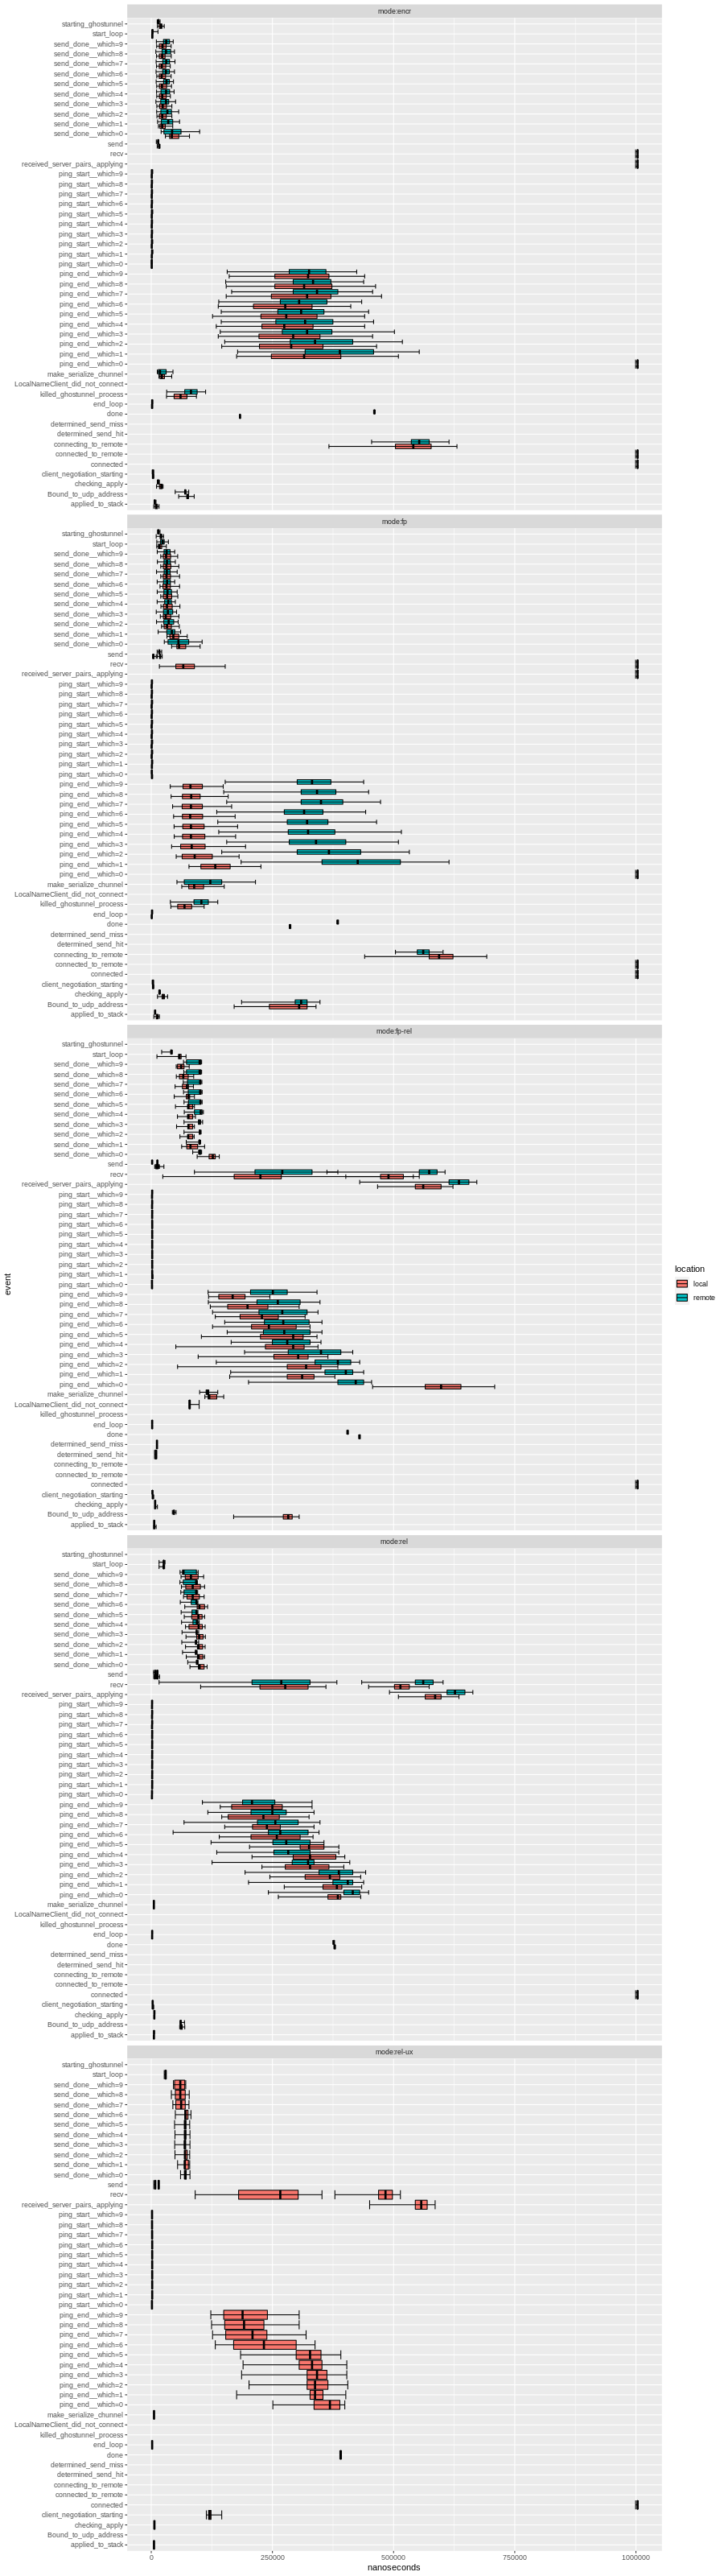

In [247]:
%%R -i df_trace -w 900 -h 3200

no_rel <- df_trace[df_trace$reliable == "no-rel",]

ggplot(no_rel, aes(x=event, fill=location)) +
  geom_crossbar(aes(ymin=p25, y=p50, ymax=p75), position="dodge") + 
  geom_errorbar(aes(ymin=min, ymax=p95), position="dodge") +
  facet_wrap(~mode, ncol=1) +
  ylab("nanoseconds") +
  coord_cartesian(ylim=c(0, 1000e3)) +
  coord_flip() 

Unix Latencies

quantiles p25, p50, p75, p95, all in us

docker:
with trace: [311, 338, 368, 418]
no trace: [201, 231, 283, 377]

no docker:
no trace: [184, 228, 289, 347]

script (docker):
trace: [437, 470, 501, 560]
no prints: [265, 302, 409, 440]

In [187]:
srv_df_trace = None
for d in version:
    for p in pos:
        for m in mode:
            for nummsg in msgs:
                for pc in perconn:
                    fn = f"{d}/{p}-{m}-{nummsg}-{pc}.srvtrace"
                    try:
                        file_df = pd.DataFrame.from_records(parse_trace(fn))
                    except:
                        print(f"skip {fn}")
                        continue
                    file_df['reliable'] = d
                    file_df['location'] = p
                    file_df['mode'] = m
                    file_df['nummsg'] = nummsg
                    file_df['perconn'] = pc
                    if srv_df_trace is None:
                        srv_df_trace = file_df
                    else:
                        srv_df_trace = srv_df_trace.append(file_df)
                    
srv_df_trace.head()

skip with-rel/local-mode:encr-msgs:200-perconn:10.srvtrace
skip with-rel/local-mode:rel-msgs:200-perconn:10.srvtrace
skip with-rel/local-mode:fp-msgs:200-perconn:10.srvtrace
skip with-rel/local-mode:fp-rel-msgs:200-perconn:10.srvtrace
skip with-rel/local-mode:fp-rel2-msgs:200-perconn:10.srvtrace
skip with-rel/remote-mode:encr-msgs:200-perconn:10.srvtrace
skip with-rel/remote-mode:rel-msgs:200-perconn:10.srvtrace
skip with-rel/remote-mode:fp-msgs:200-perconn:10.srvtrace
skip with-rel/remote-mode:fp-rel-msgs:200-perconn:10.srvtrace
skip with-rel/remote-mode:fp-rel2-msgs:200-perconn:10.srvtrace
skip no-rel/local-mode:encr-msgs:200-perconn:10.srvtrace
skip no-rel/local-mode:rel-msgs:200-perconn:10.srvtrace
skip no-rel/remote-mode:encr-msgs:200-perconn:10.srvtrace
skip no-rel/remote-mode:rel-msgs:200-perconn:10.srvtrace


,min,p25,p50,p75,p95,max,cnt,event,reliable,location,mode,nummsg,perconn
0,999424,1003519,1003519,1003519,1003519,1003519,1,pending,no-rel,local,mode:fp,msgs:200,perconn:10
1,147456,237567,276479,307199,370687,1003519,200,remote_is_up,no-rel,local,mode:fp,msgs:200,perconn:10
2,999424,1003519,1003519,1003519,1003519,1003519,200,new_connection,no-rel,local,mode:fp,msgs:200,perconn:10
3,42496,66047,68095,73215,89599,155647,200,"address_not_already_negotiated,_doing_negotiation",no-rel,local,mode:fp,msgs:200,perconn:10
4,55552,91135,96767,113663,138239,190463,200,enabling_listen,no-rel,local,mode:fp,msgs:200,perconn:10


R[write to console]: Coordinate system already present. Adding new coordinate system, which will replace the existing one.



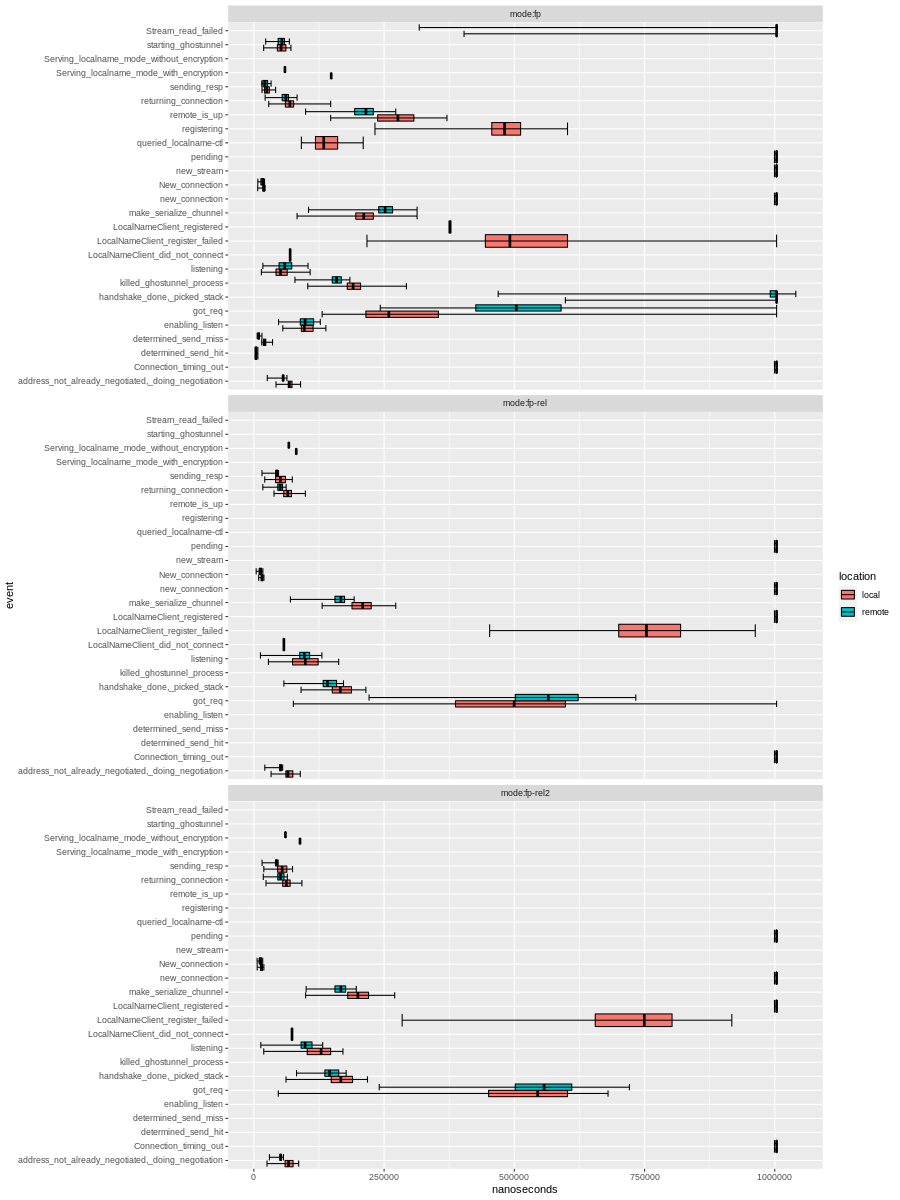

In [188]:
%%R -i srv_df_trace -w 900 -h 1200

ggplot(srv_df_trace, aes(x=event, fill=location)) +
  geom_crossbar(aes(ymin=p25, y=p50, ymax=p75), position="dodge") + 
  geom_errorbar(aes(ymin=min, ymax=p95), position="dodge") +
  facet_wrap(~mode, ncol=1) +
  ylab("nanoseconds") +
  coord_cartesian(ylim=c(0, 1000e3)) +
  coord_flip() 